## Research question 1:

1. Are inhabitants of cities more likely to have more friends than individuals living in rural areas?

Plan to answer this question:

- how many people define a city? Drop cities with less inhabitants, less population density
- convert area to radius
- for each country:
    for each home location in that country:
        is home location near city? calculate distance to city, 
        if distance < given radius, then yes
- calculate # friends per user, group by rural/city and compare amount of friends

### Libraries

In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import distance
from functions import load_data

### Load the data


#### Load home locations

In [104]:
B_homes = pd.read_pickle("B_homes.pickle")
G_homes = pd.read_pickle("G_homes.pickle")

B_homes.columns = B_homes.columns.droplevel(1)
G_homes.columns = G_homes.columns.droplevel(1)

In [105]:
# Introduce a unique index per user
B_homes['user'] = B_homes.index
G_homes['user'] = G_homes.index

In [106]:
B_homes.head()

,longitude,latitude,country,user
user_id,,,,
0,-105.009140,39.756108,US,0
1,-122.353819,37.581821,US,1
2,-105.041977,39.771737,US,2
3,-122.424280,37.765768,US,3
4,24.937299,60.173985,FI,4


#### Load cities

In [25]:
cities = pd.read_csv("city_and_area.csv").drop(columns = ['Unnamed: 0'], axis = 1)

In [8]:
cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id,area
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764,2194.07
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077,7062.50
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,Delhi,admin,29617000.0,1356872604,1484.00
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,Mahārāshtra,admin,23355000.0,1356226629,4355.00
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140,1474.82


#### Load edges

In [81]:
_, B_edges = load_data("Brightkite")
_, G_edges = load_data("Gowalla")

### Deal with the cities

1. Calculate population density
2. Drop cities with # inhabitants < 50.000 and population density < 1500 ([How we define cities](https://blogs.worldbank.org/sustainablecities/how-do-we-define-cities-towns-and-rural-areas))
       The Degree of Urbanization identifies cities as cities, if they have a population of at least 50,000 inhabitants in contiguous dense grid cells (>1,500 inhabitants per km2);
3. Calculate the radius for each city


In [27]:
# 1. Calculate population density
cities['density'] = cities['population'] / cities['area']

In [28]:
# 2. Drop cities with # inhabitants < 50.000 and population density < 1500
cities = cities[(cities['population'] > 50000) & (cities['density'] > 1500)]

In [39]:
# 3. Calculate the radius for each city
def radius(A):
    return np.sqrt(A/np.pi)

cities['radius'] = cities['area'].apply(lambda x: radius(x))

In [40]:
cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id,area,density,radius
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764,2194.07,17308.928156,26.427148
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077,7062.50,4890.619469,47.413749
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,Delhi,admin,29617000.0,1356872604,1484.00,19957.547170,21.734118
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,Mahārāshtra,admin,23355000.0,1356226629,4355.00,5362.801378,37.232238
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140,1474.82,15654.791771,21.666790


### Does user live in rural or urban area?

  for each country:
  
    for each home location in that country:
        is home location near city? calculate distance to city, 
        if distance < given radius, then yes



In [107]:
# Take a subset for now
B_homes = B_homes.sample(200, random_state=1)
G_homes = G_homes.sample(200, random_state=1)

In [108]:
# Create a huge dataframe with all cities per country to then check if a home location is close to a city
B_merge = B_homes.merge(cities, left_on = 'country', right_on = 'iso2')
G_merge = G_homes.merge(cities, left_on = 'country', right_on = 'iso2')

In [109]:
B_merge['distance_to_city'] = B_merge.apply(lambda row: distance((row['latitude'], row['longitude']), (row['lat'],row['lng']) ).km, axis = 1)
G_merge['distance_to_city'] = G_merge.apply(lambda row: distance((row['latitude'], row['longitude']), (row['lat'],row['lng']) ).km, axis = 1)


In [110]:
B_merge.head()

,longitude,latitude,country_x,user,city,city_ascii,lat,lng,country_y,iso2,iso3,admin_name,capital,population,id,area,density,radius,distance_to_city
0,-116.203451,43.6135,US,18790,Los Angeles,Los Angeles,34.1139,-118.4068,United States,US,USA,California,NaN,12750807.0,1840020491,4850.00,2629.032371,39.291258,1071.665474
1,-116.203451,43.6135,US,18790,Dallas,Dallas,32.7936,-96.7662,United States,US,USA,Texas,NaN,5743938.0,1840019440,1407.20,4081.820637,21.164255,2074.975030
2,-116.203451,43.6135,US,18790,Philadelphia,Philadelphia,40.0077,-75.1339,United States,US,USA,Pennsylvania,NaN,5649300.0,1840000673,142.70,39588.647512,6.739645,3401.119974
3,-116.203451,43.6135,US,18790,Houston,Houston,29.7863,-95.3889,United States,US,USA,Texas,NaN,5464251.0,1840020925,1062.00,5145.245763,18.386003,2399.046326
4,-116.203451,43.6135,US,18790,San Diego,San Diego,32.8312,-117.1225,United States,US,USA,California,NaN,3220118.0,1840021990,372.42,8646.469040,10.887836,1199.531108


In [111]:
B_lives_urban = B_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
B_lives_urban = B_lives_urban.rename(columns = {0:'lives_urban'})

G_lives_urban = G_merge.groupby("user").apply(lambda x: (x['distance_to_city'] < x['radius']).any()).to_frame()
G_lives_urban = G_lives_urban.rename(columns = {0:'lives_urban'})

In [112]:
# Integrate the 'lives_urban' variable into the home location datasets
B_homes = B_homes.merge(B_lives_urban, left_on = 'user', right_index = True)
G_homes = G_homes.merge(G_lives_urban, left_on = 'user', right_index = True)

In [113]:
B_homes.head()
G_homes.head()

,longitude,latitude,country,user,lives_urban
user_id,,,,,
76280,-117.886019,33.801853,US,76280,False
186772,17.227778,62.410301,SE,186772,False
55115,-121.305415,44.064791,US,55115,False
28361,-86.806300,33.482397,US,28361,True
132303,11.984316,57.693889,SE,132303,False


## calculate # friends per user, group by rural/city and compare amount of friends


In [114]:
B_friends = B_edges.groupby('from_id').count()
G_friends = G_edges.groupby('from_id').count()

In [115]:
B_homes = B_homes.merge(B_friends, left_on = 'user', right_index = True).rename(columns = {'to_id':'#_friends'})
G_homes = G_homes.merge(G_friends, left_on = 'user', right_index = True).rename(columns = {'to_id':'#_friends'})

In [116]:
B_homes.head()

,longitude,latitude,country,user,lives_urban,#_friends
user_id,,,,,,
18790,-116.203451,43.613500,US,18790,True,1
50434,-2.966667,56.500000,GB,50434,False,2
52196,145.133333,-37.916667,AU,52196,False,1
26515,139.550000,35.683333,JP,26515,True,8
25999,139.678110,35.640909,JP,25999,True,10


## Compare amount of friends for urban/ rural users

In [121]:
B_homes.groupby('lives_urban')['#_friends'].describe()

,count,mean,std,min,25%,50%,75%,max
lives_urban,,,,,,,,
False,124.0,7.766129,12.498526,1.0,1.0,3.0,8.0,80.0
True,70.0,10.514286,23.798516,1.0,1.0,2.0,8.0,138.0


In [134]:
G_homes.groupby('lives_urban')['#_friends'].describe()

,count,mean,std,min,25%,50%,75%,max
lives_urban,,,,,,,,
False,135.0,9.496296,18.786258,1.0,2.0,4.0,9.0,150.0
True,54.0,17.685185,45.777074,1.0,2.0,5.0,10.0,317.0


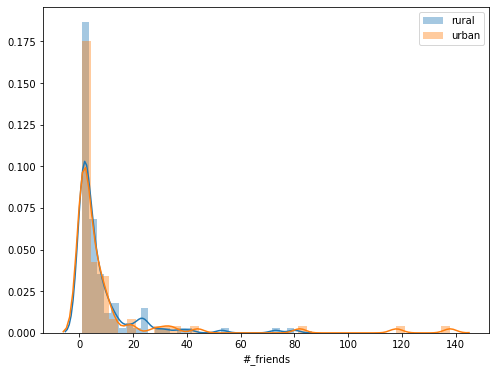

In [133]:
B_urban = B_homes[B_homes['lives_urban'] == True]
B_rural = B_homes[B_homes['lives_urban'] == False]

plt.figure(figsize=(8,6))
sns.distplot(B_rural['#_friends'], label='rural')
sns.distplot(B_urban['#_friends'], label='urban')
plt.legend();

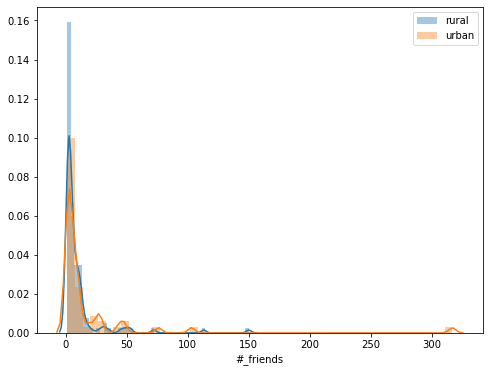

In [135]:
G_urban = G_homes[G_homes['lives_urban'] == True]
G_rural = G_homes[G_homes['lives_urban'] == False]

plt.figure(figsize=(8,6))
sns.distplot(G_rural['#_friends'], label='rural')
sns.distplot(G_urban['#_friends'], label='urban')
plt.legend();